In [ ]:
!nvidia-smi

Thu Dec 15 12:54:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install kornia
!pip install git+https://github.com/hermannsblum/bdl-benchmark.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 27.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/hermannsblum/bdl-benchmark.git to /tmp/pip-req-build-tagxav3e
  Running command git clone -q https://github.com/hermannsblum/bdl-benchmark.git /tmp/pip-req-build-tagxav3e
  Created wheel for bdlb: filename=bdlb-0.0.1-py3-none-any.whl size=46426 sha256=587d58155c70cd7684d9a7856032023fc81d44220c293cd420a36a0b0509eee0
  Stored in directory: /tmp/pip-ephem-wheel-cache-1l0g9fub/wheels/45/f7/ca/b4d266a3dfb96cc1a76f933e0ed7d8e71ca4d86b2ec8b51139
Successfully built bdlb


# Dataset

In [ ]:
!cp -r '/content/drive/MyDrive/obstacle_dataset' '/content'
# !cp -r '/content/drive/MyDrive/Data_set' '/content'

# Import

In [ ]:
%cd '/content/drive/MyDrive/Cityscapes_Segmentation'
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary
import torchvision.models as models
import torch.nn as nn
import torch

from Dataloder import Cityscapes
from SegNet import *
from UNET import *
from deeplabv3 import custom_DeepLabv3_101, custom_DeepLabv3_50

/content/drive/MyDrive/Cityscapes_Segmentation


# Initial Config

In [ ]:
NUM_CLASSES = 20
BATCH_SIZE = 4
IMAGE_SIZE = 650
NUM_EPOCHS = 50
SEED = 101

torch.manual_seed(SEED) 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataloader

In [ ]:
train_dataset = Cityscapes(root= '/content/obstacle_dataset',phase= 'train' , IMG_SIZE = IMAGE_SIZE, num_classes = NUM_CLASSES)
val_dataset   = Cityscapes(root= '/content/obstacle_dataset',phase= 'val'   , IMG_SIZE = IMAGE_SIZE, num_classes = NUM_CLASSES)

Total Number of Images: 1036
Total Number of Masks : 1036
Total Number of Images: 1203
Total Number of Masks : 1203


In [ ]:
from torch.utils.data import Dataset, DataLoader
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last = True)
val_data_loader   = DataLoader(val_dataset  , batch_size=BATCH_SIZE, drop_last = True)

In [ ]:
X, Y = next(iter(val_data_loader))
print('X shape:', X.shape, X.dtype)
print('Y shape:', Y.shape, Y.dtype)
X, Y = X.to(device), Y.to(device)

X shape: torch.Size([4, 3, 650, 650]) torch.float32
Y shape: torch.Size([4, 20, 650, 650]) torch.int64


In [ ]:
y = torch.argmax(Y, dim=1)
print(y[0].shape)

torch.Size([650, 650])


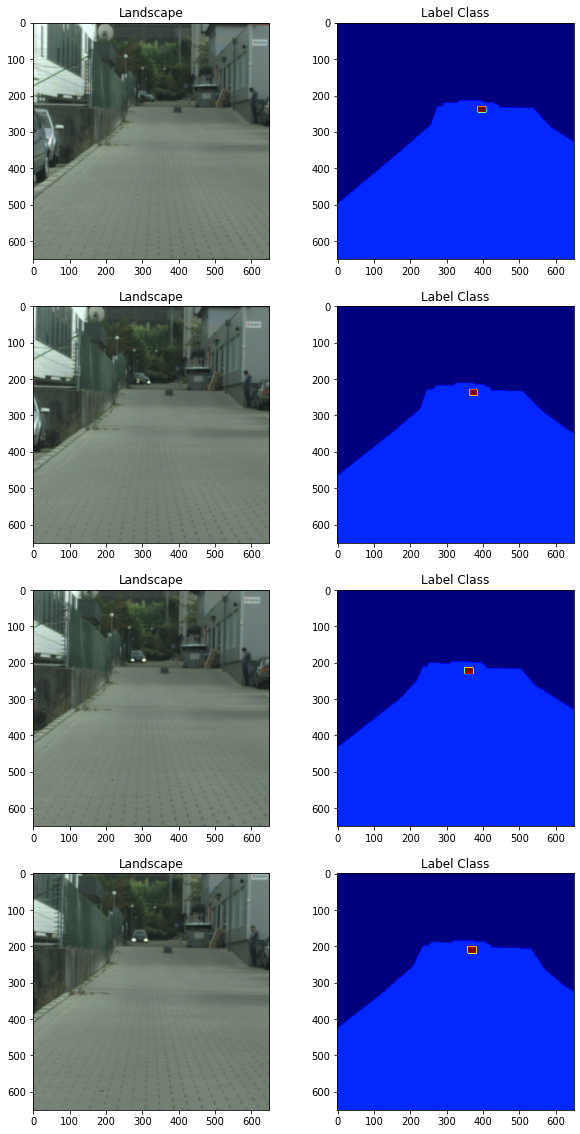

In [ ]:
fig, axes = plt.subplots(BATCH_SIZE, 2, figsize=(2*5, BATCH_SIZE*5))

for i in range(BATCH_SIZE):
    
    landscape = X[i].permute(1, 2, 0).cpu().detach().numpy()
    label_class = y[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")

    axes[i, 1].imshow(label_class, cmap = 'jet')
    axes[i, 1].set_title("Label Class")

# Model

In [ ]:
# UNet(out_channels=NUM_CLASSES)
model = custom_DeepLabv3_101(out_channel=NUM_CLASSES)
model.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# Metrics

In [ ]:
def MeanIoU(num_classes, target, pred):
  mIoU = 0

  for i in range(num_classes):
    
    intersection = torch.logical_and(target[i].int(), pred[i].int())
    union = torch.logical_or(target[i].int(), pred[i].int())
    iou_score = torch.sum(intersection) / torch.sum(union)
    
    if (torch.sum(union) == 0):
      iou_score = 1
    
    mIoU = mIoU + iou_score
  
  return mIoU / num_classes

In [ ]:
def label_categorization(img, H = IMAGE_SIZE, W = IMAGE_SIZE):
  channled_mask = torch.zeros((NUM_CLASSES, H, W)) 
  for i in range(NUM_CLASSES):
    # Converting [1, IMAGE_SIZE, IMAGE_SIZE] to [num_classes, 1024, 2048]
    channled_mask[i][img.squeeze() == i] = 1     
  return channled_mask

In [ ]:
def binary_mask(self, img):
  for i in range(self.num_classes):
    img[i] = (img[i] > 0.50).float() 
  return img

# Loading Model

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/deeplab101_50_epoch.pt'))
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

# Post Processing the Output

In [ ]:
X, Y = next(iter(val_data_loader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred['out'].shape)

torch.Size([4, 20, 650, 650])


pred values :  tensor([0, 1], device='cuda:0')
pred values :  tensor([0, 1], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0, 1], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')
pred values :  tensor([0], device='cuda:0')


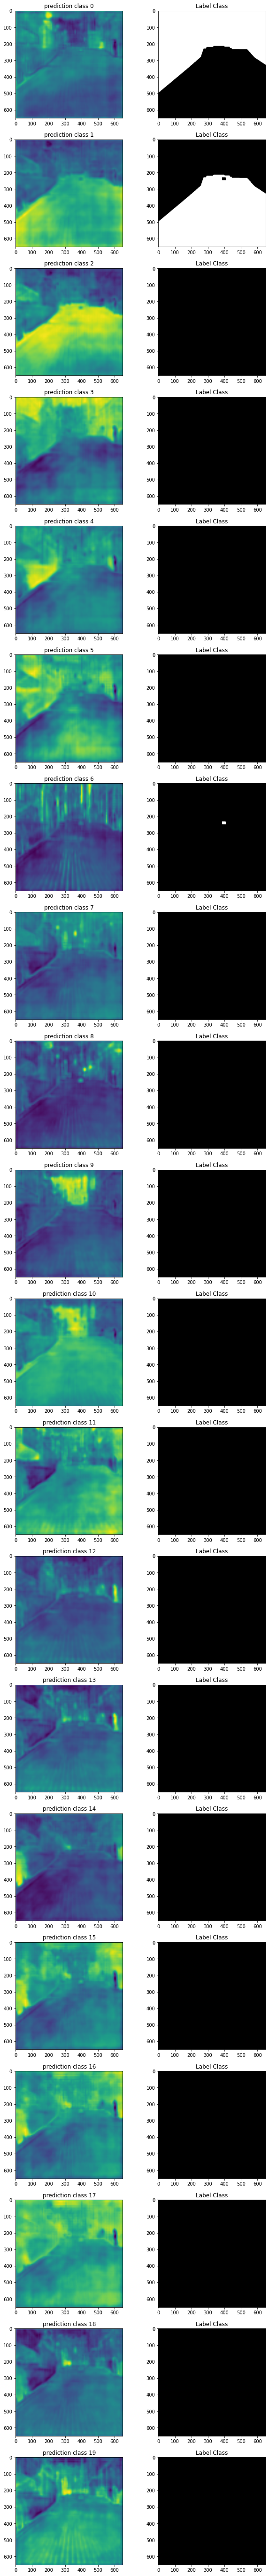

In [ ]:
fig, axes = plt.subplots(NUM_CLASSES, 2, figsize=(2*5, NUM_CLASSES*5))

for i in range(NUM_CLASSES):

  # print('pred values : ',torch.unique(Y_pred['out'][0][i]))
  pred = Y_pred['out'][0][i].cpu().detach().numpy()

  print('pred values : ',torch.unique(Y[0][i]))
  label_class = Y[0][i].cpu().detach().numpy()

  axes[i, 0].imshow(pred)
  axes[i, 0].set_title(f"prediction class {i}")

  axes[i, 1].imshow(label_class, cmap = 'gray')
  axes[i, 1].set_title("Label Class")

## Statistics Calculation

In [ ]:
Y_pred['out'][0:1].shape
L, y_hat = torch.max(Y_pred['out'], dim=1)

In [ ]:
import numpy as np

var_dict  = {}
mean_dict = {}
SML = L
for i in range(NUM_CLASSES):
  var_dict[i] = L[y_hat == i].var()
  mean_dict[i] = L[y_hat == i].mean()
  SML[y_hat == i] = (SML[y_hat == i] - mean_dict[i]) / np.sqrt(var_dict[i].cpu().detach().numpy())


<a list of 100 Patch objects>

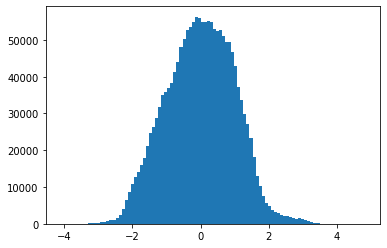

In [ ]:
plot = SML.cpu().detach().numpy()
plt.hist(plot.flat, bins = 100)[2]

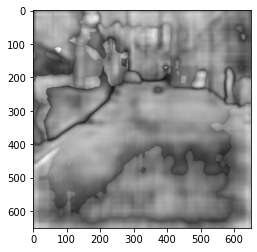

In [ ]:
plt.imshow(plot[1], cmap = 'gray')

In [ ]:
from kornia.morphology import dilation, erosion
from scipy import ndimage as ndi
import math

selem = torch.ones((3, 3)).cuda()
selem_dilation = torch.FloatTensor(ndi.generate_binary_structure(2, 1)).cuda()

# NOTE(shjung13): Dilation filters to expand the boundary maps (L1)
d_k1 = torch.zeros((1, 1, 2 * 1 + 1, 2 * 1 + 1)).cuda()
d_k2 = torch.zeros((1, 1, 2 * 2 + 1, 2 * 2 + 1)).cuda()
d_k3 = torch.zeros((1, 1, 2 * 3 + 1, 2 * 3 + 1)).cuda()
d_k4 = torch.zeros((1, 1, 2 * 4 + 1, 2 * 4 + 1)).cuda()
d_k5 = torch.zeros((1, 1, 2 * 5 + 1, 2 * 5 + 1)).cuda()
d_k6 = torch.zeros((1, 1, 2 * 6 + 1, 2 * 6 + 1)).cuda()
d_k7 = torch.zeros((1, 1, 2 * 7 + 1, 2 * 7 + 1)).cuda()
d_k8 = torch.zeros((1, 1, 2 * 8 + 1, 2 * 8 + 1)).cuda()
d_k9 = torch.zeros((1, 1, 2 * 9 + 1, 2 * 9 + 1)).cuda()

d_ks = {1: d_k1, 2: d_k2, 3: d_k3, 4: d_k4, 5: d_k5, 6: d_k6, 7: d_k7, 8: d_k8, 9: d_k9}


for k, v in d_ks.items():
    v[:,:,k,k] = 1
    for i in range(k):
        v = dilation(v, selem_dilation)
    d_ks[k] = v.squeeze(0).squeeze(0)

    print(f'dilation kernel at {k}:\n\n{d_ks[k]}')


def find_boundaries(label):
    """
    Calculate boundary mask by getting diff of dilated and eroded prediction maps
    """
    assert len(label.shape) == 4
    boundaries = (dilation(label.float(), selem_dilation) != erosion(label.float(), selem)).float()
    ### save_image(boundaries, f'boundaries_{boundaries.float().mean():.2f}.png', normalize=True)

    return boundaries

def expand_boundaries(boundaries, r=0):
    """
    Expand boundary maps with the rate of r
    """
    if r == 0:
        return boundaries
    expanded_boundaries = dilation(boundaries, d_ks[r])
    ### save_image(expanded_boundaries, f'expanded_boundaries_{r}_{boundaries.float().mean():.2f}.png', normalize=True)
    return expanded_boundaries

In [ ]:
class BoundarySuppressionWithSmoothing(nn.Module):
    """
    Apply boundary suppression and dilated smoothing
    """
    def __init__(self, boundary_suppression=True, boundary_width=4, boundary_iteration=4,
                 dilated_smoothing=True, kernel_size=7, dilation=6):
        super(BoundarySuppressionWithSmoothing, self).__init__()
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.boundary_suppression = boundary_suppression
        self.boundary_width = boundary_width
        self.boundary_iteration = boundary_iteration

        sigma = 1.0
        size = 7
        gaussian_kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
        gaussian_kernel /= np.sum(gaussian_kernel)
        gaussian_kernel = torch.Tensor(gaussian_kernel).cuda().unsqueeze(0).unsqueeze(0)
        self.dilated_smoothing = dilated_smoothing

        self.first_conv = nn.Conv2d(1, 1, kernel_size=3, stride=1, bias=False).cuda()
        self.first_conv.weight = torch.nn.Parameter(torch.ones_like((self.first_conv.weight))).cuda()

        self.second_conv = nn.Conv2d(1, 1, kernel_size=self.kernel_size, stride=1, dilation=self.dilation, bias=False).cuda()
        self.second_conv.weight = torch.nn.Parameter(gaussian_kernel).cuda()


    def forward(self, x, prediction=None):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x_size = x.size()
        # B x 1 x H x W
        assert len(x.shape) == 4
        out = x
        if self.boundary_suppression:
            # obtain the boundary map of width 2 by default
            # this can be calculated by the difference of dilation and erosion
            boundaries = find_boundaries(prediction.unsqueeze(1))
            expanded_boundaries = None
            if self.boundary_iteration != 0:
                assert self.boundary_width % self.boundary_iteration == 0
                diff = self.boundary_width // self.boundary_iteration
            for iteration in range(self.boundary_iteration):
                if len(out.shape) != 4:
                    out = out.unsqueeze(1)
                prev_out = out
                # if it is the last iteration or boundary width is zero
                if self.boundary_width == 0 or iteration == self.boundary_iteration - 1:
                    expansion_width = 0
                # reduce the expansion width for each iteration
                else:
                    expansion_width = self.boundary_width - diff * iteration - 1
                # expand the boundary obtained from the prediction (width of 2) by expansion rate
                expanded_boundaries = expand_boundaries(boundaries, r=expansion_width)
                # invert it so that we can obtain non-boundary mask
                non_boundary_mask = 1. * (expanded_boundaries == 0)

                f_size = 1
                num_pad = f_size

                # making boundary regions to 0
                x_masked = out * non_boundary_mask
                x_padded = nn.ReplicationPad2d(num_pad)(x_masked)

                non_boundary_mask_padded = nn.ReplicationPad2d(num_pad)(non_boundary_mask)

                # sum up the values in the receptive field
                y = self.first_conv(x_padded)
                # count non-boundary elements in the receptive field
                num_calced_elements = self.first_conv(non_boundary_mask_padded)
                num_calced_elements = num_calced_elements.long()

                # take an average by dividing y by count
                # if there is no non-boundary element in the receptive field,
                # keep the original value
                avg_y = torch.where((num_calced_elements == 0), prev_out, y / num_calced_elements)
                out = avg_y

                # update boundaries only
                out = torch.where((non_boundary_mask == 0), out, prev_out)
                del expanded_boundaries, non_boundary_mask

            # second stage; apply dilated smoothing
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)

            return out.squeeze(1)
        else:
            if self.dilated_smoothing == True:
                out = nn.ReplicationPad2d(self.dilation * 3)(out)
                out = self.second_conv(out)
            else:
                out = x

        return out.squeeze(1)


In [ ]:
multi_scale = BoundarySuppressionWithSmoothing(
        boundary_suppression=True,
        boundary_width=4,
        boundary_iteration=4,
        dilated_smoothing=True,
        kernel_size=7,
        dilation=6)

In [ ]:
anomaly_score = multi_scale(SML, y_hat)

In [ ]:
anomaly_score.shape

torch.Size([4, 650, 650])

In [ ]:
y = torch.argmax(Y, dim=1)
y.shape

torch.Size([4, 650, 650])

In [ ]:
X.shape

torch.Size([4, 3, 650, 650])

Text(0.5, 1.0, 'SML')

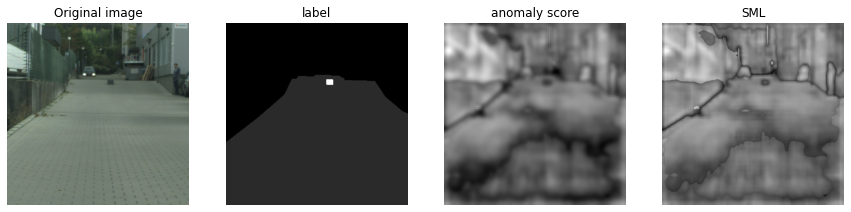

In [ ]:
image_num = 3
fig, axes = plt.subplots(1, 4, figsize=(3*5, 1*5))
axes[0].imshow((X[image_num].permute(1,2,0).cpu().detach().numpy()), cmap = 'gray')
axes[0].axis('off')
axes[0].set_title('Original image')

axes[1].imshow((y.cpu().detach().numpy())[image_num], cmap = 'gray')
axes[1].axis('off')
axes[1].set_title('label')

axes[2].imshow((anomaly_score.cpu().detach().numpy())[image_num], cmap = 'gray')
axes[2].axis('off')
axes[2].set_title('anomaly score')

axes[3].imshow((SML.cpu().detach().numpy())[image_num], cmap = 'gray')
axes[3].axis('off')
axes[3].set_title('SML')